# UniTVelo benchmark on cell cycle data

Notebook benchmarks velocity, latent time inference, and cross boundary correctness using UniTVelo on cell cycle data.

## Library imports

In [1]:
import os

import pandas as pd

import anndata as ad
import scvelo as scv
import unitvelo as utv
from cellrank.kernels import VelocityKernel

from rgv_tools import DATA_DIR
from rgv_tools.benchmarking import get_time_correlation

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

(Running UniTVelo 0.2.5.2)
2024-12-12 08:57:12


2024-12-12 09:57:43.343341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733993864.214699  903814 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733993864.758329  903814 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## General settings

In [2]:
scv.settings.verbosity = 3

In [3]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = "1"
velo_config.AGENES_R2 = 1
velo_config.GPU = -1

In [4]:
os.environ["TF_USE_LEGACY_KERAS"] = "True"

## Constants

In [5]:
DATASET = "cell_cycle"

In [6]:
STATE_TRANSITIONS = [("G1", "S"), ("S", "G2M")]

In [7]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

## Data loading

In [8]:
adata = ad.io.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'true_skeleton'
    layers: 'Ms', 'Mu', 'spliced', 'total', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

## Velocity pipeline

------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Current working dir is /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility_cell_cycle.
Results will be stored in res folder
Filtered out 16 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
Extracted 379 highly variable genes.
Computing moments for 379 genes with n_neighbors: 30 and n_pcs: 30
computing moments based on connectivities


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)

# of velocity genes 359 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 308 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 308 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 633161.429, (Spliced): 330716.701, (Unspliced): 302444.727: 100%|█████████▉| 11998/12000 [05:34<00:00, 32.97it/s]  /home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


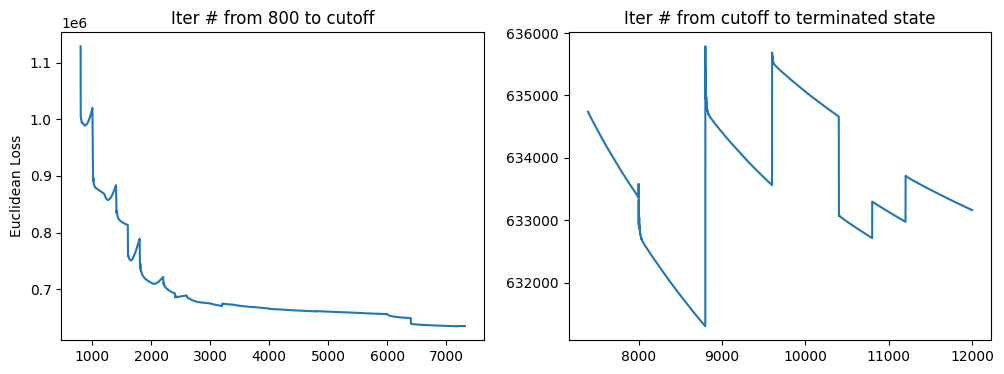

Loss (Total): 633161.429, (Spliced): 330716.701, (Unspliced): 302444.727: 100%|█████████▉| 11999/12000 [05:42<00:00, 35.00it/s]

Total loss 631298.883, vgene loss 633161.429


  0%|          | 0/1146 [00:00<?, ?cells/s]

... storing 'cluster' as categorical


In [9]:
adata.obs["cluster"] = "0"
adata = utv.run_model(adata, label="cluster", config_file=velo_config)

In [10]:
time_correlation = [get_time_correlation(ground_truth=adata.obs["fucci_time"], estimated=adata.obs["latent_time"])]

In [11]:
scv.tl.velocity_graph(adata, vkey="velocity", n_jobs=1)
scv.tl.velocity_confidence(adata, vkey="velocity")

  0%|          | 0/1146 [00:00<?, ?cells/s]

## Cross-boundary correctness

In [12]:
vk = VelocityKernel(adata, vkey="velocity").compute_transition_matrix()

cluster_key = "phase"
rep = "X_pca"

score_df = []
for source, target in STATE_TRANSITIONS:
    cbc = vk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc),
                "CBC": cbc,
            }
        )
    )
score_df = pd.concat(score_df)

  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

## Data saving

In [13]:
if SAVE_DATA:
    pd.DataFrame({"time": time_correlation}, index=adata.obs_names).to_parquet(
        path=DATA_DIR / DATASET / "results" / "unitvelo_correlation.parquet"
    )
    adata.obs[["velocity_confidence"]].to_parquet(path=DATA_DIR / DATASET / "results" / "unitvelo_confidence.parquet")
    score_df.to_parquet(path=DATA_DIR / DATASET / "results" / "unitvelo_cbc.parquet")